<a href="https://colab.research.google.com/github/shashank-dj/ML_project/blob/main/Transfer_Leranining_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part1: Feature Extraction

Transfer lerning is leveraging a working models existing architecture and learned patterns for our own problem.

There are two main benfits:
1. Can leverage an existing neural network archetecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar dat to our own , then we can adapt those patterns to our own data

In [1]:
!nvidia-smi

Mon Jul 19 09:17:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Downloading and becoming one with data

In [2]:
# get data
import zipfile
#download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-07-19 09:17:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 74.125.137.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   162MB/s    in 1.0s    

2021-07-19 09:17:28 (162 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directions and {len(filenames)} images in '{dirpath}'. ")

There are 2 directions and 0 images in '10_food_classes_10_percent'. 
There are 10 directions and 0 images in '10_food_classes_10_percent/test'. 
There are 0 directions and 250 images in '10_food_classes_10_percent/test/hamburger'. 
There are 0 directions and 250 images in '10_food_classes_10_percent/test/grilled_salmon'. 
There are 0 directions and 250 images in '10_food_classes_10_percent/test/pizza'. 
There are 0 directions and 250 images in '10_food_classes_10_percent/test/chicken_curry'. 
There are 0 directions and 250 images in '10_food_classes_10_percent/test/sushi'. 
There are 0 directions and 250 images in '10_food_classes_10_percent/test/ice_cream'. 
There are 0 directions and 250 images in '10_food_classes_10_percent/test/fried_rice'. 
There are 0 directions and 250 images in '10_food_classes_10_percent/test/chicken_wings'. 
There are 0 directions and 250 images in '10_food_classes_10_percent/test/steak'. 
There are 0 directions and 250 images in '10_food_classes_10_percent/

#Creating data loaders(preparing the data)

we will use `ImageDataGenerator` class to load in our images in batches.

In [4]:
#setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# Setting up callbacks 

callbacks are the extra functionality you can add to your models to be performed during or after training.Some of the most popular callbacks:
* Tracking experiments with the TensorBoard callback 
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training with the early stopping callback


In [5]:
# Create a Tensorboard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" +experiment_name + "/" +datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback

**Note:** You can customize the directory where your Tensorboard logs(model training metrics) get saved to whatever you like. The log_dir parameter we have created above is only one option.  

# Creating models using Tensorflow hub

In the past we have used tensorflow to create our own models layer by layer from scratch.

Now we are going to do similar process, except the majority of our model's later are going to come from Tensorflow Hub. We can access pretrianed models on: https://tfhub.dev.

Browsing the tensorflow hub page and sorting for the image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


In [6]:
# Let's compare following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = " https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# import dependencies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
#Let's make a create_model() function to create 
def create_model(model_url, num_classes=10):
  #Download the pretrained model and save it to the keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3,))#freeze already learned patterns

  #create pur own model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation="softmax", name="output_layer")

  ])
  return model

# Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
#compile resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [12]:
train_data_10_percent.num_classes

10

In [13]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files



Saving TensorBoard log files to : tensorflow_hub/resnet50V2/20210719-091741
Epoch 1/5
24/24 [==============================] - 51s 772ms/step - loss: 1.8864 - accuracy: 0.3560 - val_loss: 1.2216 - val_accuracy: 0.6000
Epoch 2/5
24/24 [==============================] - 15s 660ms/step - loss: 0.9071 - accuracy: 0.7200 - val_loss: 0.8544 - val_accuracy: 0.7256
Epoch 3/5
24/24 [==============================] - 16s 695ms/step - loss: 0.6209 - accuracy: 0.8240 - val_loss: 0.7600 - val_accuracy: 0.7536
Epoch 4/5
24/24 [==============================] - 16s 669ms/step - loss: 0.4694 - accuracy: 0.8867 - val_loss: 0.7070 - val_accuracy: 0.7740
Epoch 5/5
24/24 [==============================] - 15s 655ms/step - loss: 0.3775 - accuracy: 0.9160 - val_loss: 0.6774 - val_accuracy: 0.7808


Transfer learning feature extractor model out perform all our previous models we built by hand and with a quicker training time and with only 10 percent of training set. 

In [14]:
# create a function to plot oour loss curve
import matplotlib.pyplot as plt

def plot_loss_curve(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="validation_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuaracy")
  plt.plot(epochs, val_accuracy, label="validation_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()
  

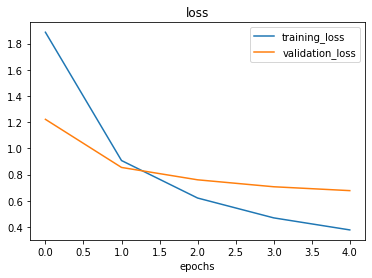

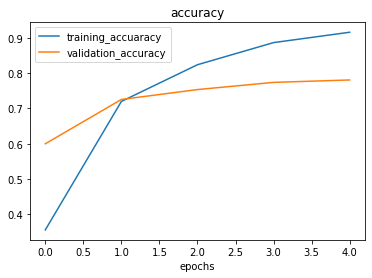

In [15]:
plot_loss_curve(resnet_history)

# Creating and testing EffecientNetB0 Tensorflow Hub feature extraction model

In [16]:
# create a efficent model
efficient_model = create_model(model_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1", num_classes = train_data_10_percent.num_classes)

#compile 
efficient_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

# fit the model
efficient_history = efficient_model.fit(train_data_10_percent,
                                           epochs=5, 
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data=test_data_10_percent,
                                           validation_steps=len(test_data_10_percent),
                                           callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                  experiment_name="EfficentNetB0")])



Saving TensorBoard log files to : tensorflow_hub/EfficentNetB0/20210719-091945
Epoch 1/5
24/24 [==============================] - 26s 817ms/step - loss: 1.8237 - accuracy: 0.4520 - val_loss: 1.2829 - val_accuracy: 0.7468
Epoch 2/5
24/24 [==============================] - 15s 639ms/step - loss: 1.0485 - accuracy: 0.7733 - val_loss: 0.8560 - val_accuracy: 0.8272
Epoch 3/5
24/24 [==============================] - 15s 626ms/step - loss: 0.7490 - accuracy: 0.8360 - val_loss: 0.6892 - val_accuracy: 0.8496
Epoch 4/5
24/24 [==============================] - 15s 626ms/step - loss: 0.6047 - accuracy: 0.8600 - val_loss: 0.6027 - val_accuracy: 0.8632
Epoch 5/5
24/24 [==============================] - 15s 657ms/step - loss: 0.5089 - accuracy: 0.8867 - val_loss: 0.5544 - val_accuracy: 0.8696


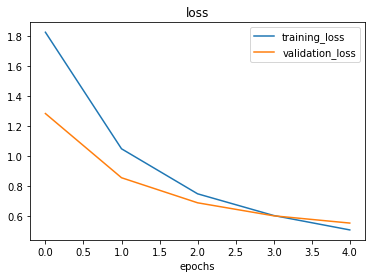

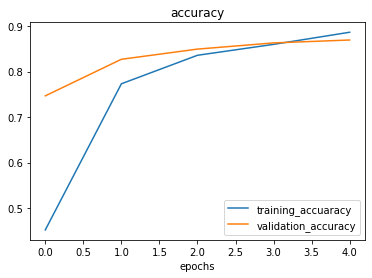

In [17]:
plot_loss_curve(efficient_history)

# Comparing our models results using TensorBoard

In [18]:
# Upload TensorBoard dev records 
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 Vs. ResNet50V2" \
  --description "comapring two TF Hub feature model architecture using 10% training data"\y

2021-07-19 09:34:57.487489: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

In [19]:
# check out what Tensorboard experiments you have
!tensorboard dev list


2021-07-19 09:40:04.839965: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/Gud6zlebQCe46eeT4MDGFg/
	Name                 EfficientNetB0 Vs. ResNet50V2
	Description          comapring two TF Hub feature model architecture using 10% training data
	Id                   Gud6zlebQCe46eeT4MDGFg
	Created              2021-07-19 09:35:31 (4 minutes ago)
	Updated              2021-07-19 09:35:33 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  6086643
Total: 1 experiment(s)
